In [48]:
# Import necessary libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Still used for image processing tasks

# Helper function to convert PIL Image to OpenCV format
def pil_to_cv(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Implement getCorners method below. You are allowed to use off the shelf detectors as shown in https://docs.opencv.org/3.4/d4/d8c/tutorial_py_shi_tomasi.html. The method must return the coordinates of the corners.

In [80]:
def getCorners(img, numCorners):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, numCorners, 0.01, 10)
    corners = np.int0(corners)
    return corners.reshape(-1, 2)

# Implement getFeatures method below. The method will compute HoG features of an image based on corner information provided by getCorners. You must implement the code yourself and are not allowed to use off the self HoG detectors in OpenCV

In [81]:
def getFeatures(img,corners):
    """
    This function computes Histogram of Gradient (HoG) features for an image based on corner points.

    Args:
    - img: The input image
    - corners: An array containing the coordinates of corner points

    Returns:
    - features: An array containing the computed HoG features for each corner point
    """
    features = []
    for corner in corners:
        x, y = corner.ravel()
        if x < 4 or y < 4 or x > img.shape[1]-5 or y > img.shape[0]-5:
            continue
        patch = img[y-4:y+4, x-4:x+4]
        sobelx = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        orientation = np.arctan2(sobely, sobelx)
        hist, _ = np.histogram(orientation, bins=16, range=(-np.pi, np.pi), weights=magnitude)
        hist /= (np.sum(hist) + 1e-6)
        features.append(hist)
    return np.array(features)

# Implement getMatches method below. The method will match features of two different images. You must implement the code yourself and are not allowed to use off the self feature detectors in OpenCV.

In [82]:
def getMatches(feat1, feat2, threshold=0.8):
    """
    This function matches features between two images based on HoG feature vectors.

    Args:
    - feat1: Array containing HoG features of image 1
    - feat2: Array containing HoG features of image 2
    - threshold: Threshold for accepting a match (default is 0.8)

    Returns:
    - matches: A list of cv2.DMatch objects representing matched features between the two images
    """
    matches = []
    for i, f1 in enumerate(feat1):
        min_dist = float('inf')
        match_idx = -1
        for j, f2 in enumerate(feat2):
            dist = 1 - np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
            if dist < min_dist:
                min_dist = dist
                match_idx = j
        if min_dist < threshold:
            matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=match_idx, _distance=min_dist))
    return matches



# The starter code for Problem 5 is shown below. You have to implement the portions in ##

C:\Users\User\AppData\Local\Temp\ipykernel_7500\2495920055.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


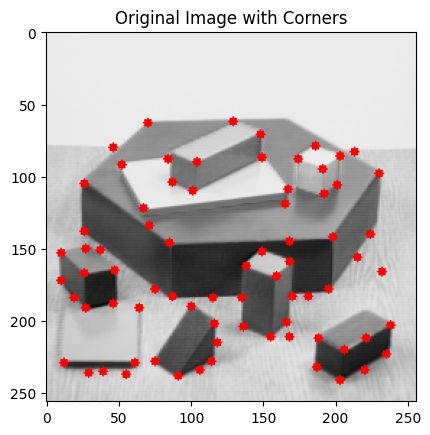

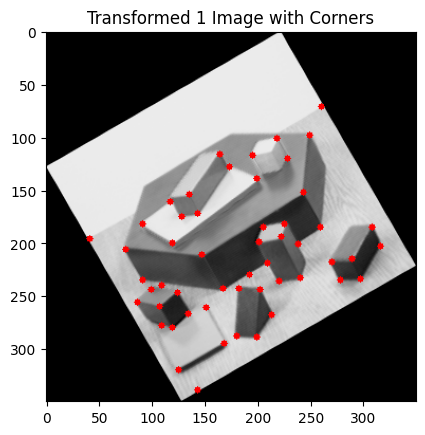

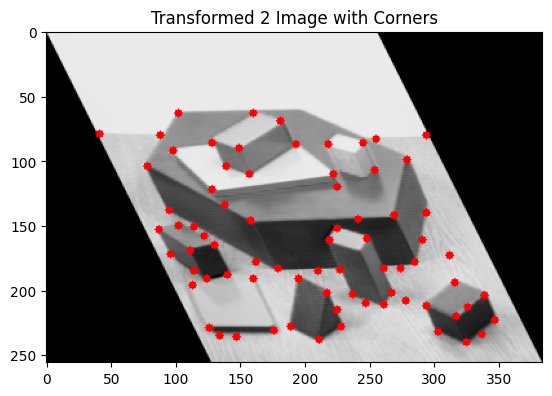

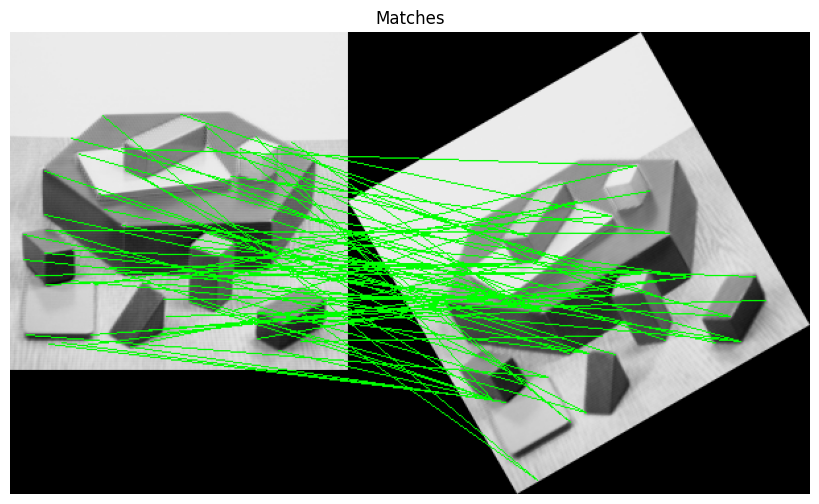

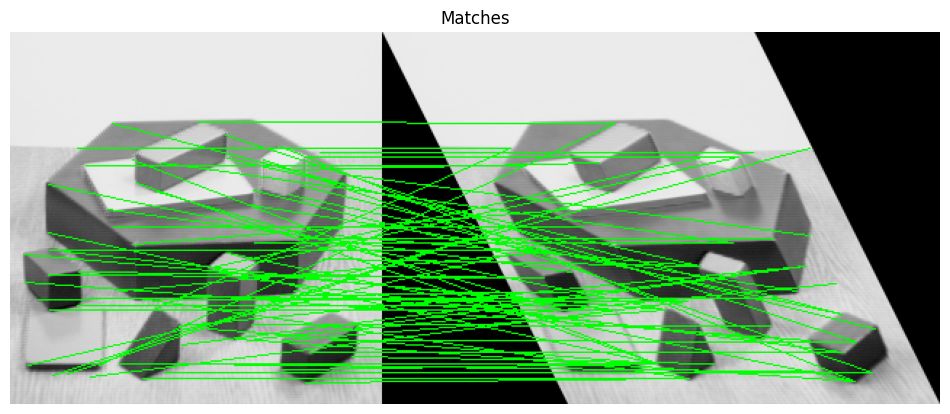

In [83]:

# Load images using PIL and convert to OpenCV format
orig_I = pil_to_cv(Image.open('blocks.png'))
trf1_I = pil_to_cv(Image.open('blocks_tform1.png'))
trf2_I = pil_to_cv(Image.open('blocks_tform2.png'))

# Plotting function to visualize images with corners
def plot_corners(img, corners, title):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Function to plot matches
def plotMatches(image1, corners1, image2, corners2, matches):
    # Convert images to RGB format
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    # Create a new image to draw matches
    img_matches = np.zeros((max(image1_rgb.shape[0], image2_rgb.shape[0]), 
                            image1_rgb.shape[1] + image2_rgb.shape[1], 3), dtype=np.uint8)
    
    # Copy the images into the new image
    img_matches[:image1_rgb.shape[0], :image1_rgb.shape[1]] = image1_rgb
    img_matches[:image2_rgb.shape[0], image1_rgb.shape[1]:] = image2_rgb
    
    # Draw lines between matched keypoints
    for match in matches:
        idx1 = match.queryIdx
        idx2 = match.trainIdx
        (x1, y1) = corners1[idx1]
        (x2, y2) = corners2[idx2]
        cv2.line(img_matches, (int(x1), int(y1)), (int(x2) + image1_rgb.shape[1], int(y2)), (0, 255, 0), 1)
    
    # Display the matches
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title('Matches')
    plt.axis('off')
    plt.show()



# Display images with detected corners
numCorners = 75
corners_orig_I = getCorners(orig_I, numCorners)
corners_trf1_I = getCorners(trf1_I, numCorners)
corners_trf2_I = getCorners(trf2_I, numCorners)

plot_corners(orig_I, corners_orig_I, "Original Image with Corners")
plot_corners(trf1_I, corners_trf1_I, "Transformed 1 Image with Corners")
plot_corners(trf2_I, corners_trf2_I, "Transformed 2 Image with Corners")

# Compute HoG features and match them
feat_orig_I = getFeatures(orig_I, corners_orig_I)
feat_trf1_I = getFeatures(trf1_I, corners_trf1_I)
feat_trf2_I = getFeatures(trf2_I, corners_trf2_I)
matches1 = getMatches(feat_orig_I, feat_trf1_I)
matches2 = getMatches(feat_orig_I, feat_trf2_I)

# Plot matches for original image and transformed image 1
plotMatches(orig_I, corners_orig_I, trf1_I, corners_trf1_I, matches1)

# Plot matches for original image and transformed image 2
plotMatches(orig_I, corners_orig_I, trf2_I, corners_trf2_I, matches2)
